<a href="https://colab.research.google.com/github/dcastf01/Datathon-Marine-2022-spegc/blob/main/02_trainClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify spoken numbers 0-9 with PylotWhale

* In this notebook we use [pylotWhale](https://github.com/floreencia/pylotwhale) to classify audio signals of spoken digits (0-9)
* We use the [AudioMNIST dataset](https://github.com/soerenab/AudioMNIST)
* In a previous notebook (01_createAnnsDataframe.ipynb) we created a dataframe with the paths to the audio files and their labels
* Training the model takes ca. 10 minutes in my 2019 MacBook. To reduce this time you can decrease the size of the training.   

In [1]:
#Instalamos la utilidad para montar
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
OK
27 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 12.1 MB of archives.
After this operation, 27.6 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.7_amd64.deb ...
Unpacking gcsfuse (0.41.7) ...
Setting up gcsfuse (0.41.7) ...


In [2]:
!wget https://storage.googleapis.com/datathon2022/my-service-account.json

--2022-10-25 20:03:53--  https://storage.googleapis.com/datathon2022/my-service-account.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2332 (2.3K) [application/json]
Saving to: ‘my-service-account.json’

my-service-account. 100%[===================>]   2.28K  --.-KB/s    in 0s      

2022-10-25 20:03:53 (41.9 MB/s) - ‘my-service-account.json’ saved [2332/2332]



In [3]:
!mkdir data
!umount data
!gcsfuse --key-file /content/my-service-account.json --implicit-dirs datathon2022 data

umount: data: not mounted.
2022/10/25 20:03:54.319667 Start gcsfuse/0.41.7 (Go version go1.18.4) for app "" using mount point: /content/data
2022/10/25 20:03:54.341085 Opening GCS connection...
2022/10/25 20:03:54.713113 Mounting file system "datathon2022"...
2022/10/25 20:03:54.714563 File system has been successfully mounted.


In [4]:
!git clone https://github.com/floreencia/pylotwhale.git

Cloning into 'pylotwhale'...
remote: Enumerating objects: 4038, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 4038 (delta 80), reused 110 (delta 62), pack-reused 3895
Receiving objects: 100% (4038/4038), 29.69 MiB | 20.31 MiB/s, done.
Resolving deltas: 100% (2366/2366), done.


## Settings

### Import modules

In [1]:
cd pylotwhale

/content/pylotwhale


In [2]:
import sys
import os
from importlib import reload

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa as lb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split #cross_val_score
import sklearn.metrics as mt

import pylotwhale.utils.plotTools as pT
import pylotwhale.MLwhales.MLtools_beta as myML
import pylotwhale.MLwhales.featureExtraction as fex
import pylotwhale.MLwhales.MLEvalTools as evT
from pylotwhale.MLwhales.clf_pool import svc_l, svc_rbf, random_forest # as clf_settings

### Set paths

In [3]:
path='/content/data/labels_dataset1_v2.csv'
collectionF = path
oFigDir = '/content/'

### Load collection dataframe

In [4]:
colldf = pd.read_csv(collectionF, )
colldf['file'] = colldf.path.apply(lambda p: '/content/data/dataset1/' + (p + '.wav'))
# Inspect dataset
print("Dataset size", len(colldf))
print(colldf['label'].value_counts())
print(colldf.info())
colldf.head()

Dataset size 5459
whistle              2879
click                2077
cetaceans_allfreq     476
allfreq                23
volcano                 4
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5459 entries, 0 to 5458
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   path      5459 non-null   object 
 1   start     5459 non-null   float64
 2   duration  5459 non-null   float64
 3   end       5459 non-null   float64
 4   label     5459 non-null   object 
 5   file      5459 non-null   object 
dtypes: float64(3), object(3)
memory usage: 256.0+ KB
None


,path,start,duration,end,label,file
0,012213d40662f86e8f775379bbf94dec,61.186,2.500,63.686,whistle,/content/data/dataset1/012213d40662f86e8f77537...
1,0159af9f3ca04ada46f0c353ac210bb8,76.260,17.000,93.260,cetaceans_allfreq,/content/data/dataset1/0159af9f3ca04ada46f0c35...
2,0159af9f3ca04ada46f0c353ac210bb8,161.482,1.000,162.482,click,/content/data/dataset1/0159af9f3ca04ada46f0c35...
3,0271a0818427d7fae7afde67bf49ba30,91.563,1.000,92.563,click,/content/data/dataset1/0271a0818427d7fae7afde6...
4,0271a0818427d7fae7afde67bf49ba30,125.627,1.316,126.943,click,/content/data/dataset1/0271a0818427d7fae7afde6...


In [5]:
colldf=colldf[colldf['label']!='volcano']

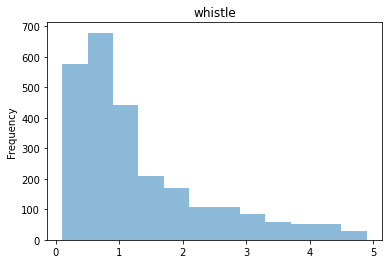

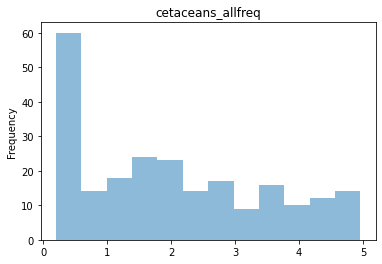

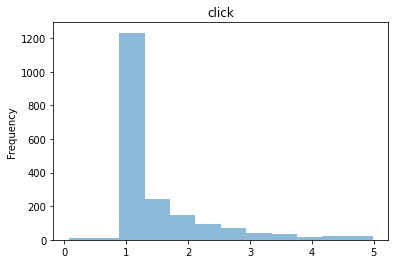

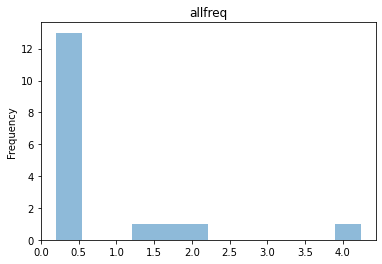

In [6]:
for label in colldf.label.unique():
    df_aux=colldf[colldf['label']==label]
    df_aux=df_aux[df_aux['duration']<5]
    df_aux.duration.plot.hist(bins=12, alpha=0.5,title=label)
    plt.show()

## Visualise data


In [7]:
def visualiseSample(i, df, oFigDir):
    """
    Parameters
    ----------
    i: int
        index of the sample
    df: DataFrame
        dataframe with annotations t0, tf, wavF, annF, l   
    oFigDir: string
        directory where to save the spectrograms
    """
    thisRec = df.iloc[i].to_dict()

    #print(thisRec['label'])
    ## load audio file
    print(thisRec)
    yi, sr = lb.core.load(thisRec['file'], sr=None,offset=thisRec['start'],duration=thisRec['duration'])
    
    ## plot spectrum
    fig, ax = plt.subplots(figsize=(2,4))

    fig, ax = pT.plspectro(yi, sr, spec_fac=1, ax=ax, 
                       xl='time (s)', yl='frequency (kHz)', cmN='viridis', fig=fig)

    ax.text(0.1, 20, '{}'.format(thisRec['label']), style='italic', fontsize=20,
            bbox={'facecolor':'white', 'alpha':0.75, 'pad':5})

    oFig = os.path.join(oFigDir, '{}_{}s.png'.format( os.path.splitext(os.path.basename(thisRec['file']))[0], i))
    #print(oFig)
    fig.savefig(oFig, bbox_inches='tight')
    return oFig

### Visualise 10 random samples

{'path': '5a8e5cfdab183be547b06ec85d216acb', 'start': 178.687, 'duration': 3.558999999999969, 'end': 182.246, 'label': 'click', 'file': '/content/data/dataset1/5a8e5cfdab183be547b06ec85d216acb.wav'}
{'path': 'adb6653b51497193baadee8acdec4af8', 'start': 70.95600000000002, 'duration': 0.3999999999999772, 'end': 71.356, 'label': 'whistle', 'file': '/content/data/dataset1/adb6653b51497193baadee8acdec4af8.wav'}
{'path': '5f39e6c968eeab87b8ba78113b42711c', 'start': 173.08999999999992, 'duration': 0.3000000000001819, 'end': 173.3900000000001, 'label': 'whistle', 'file': '/content/data/dataset1/5f39e6c968eeab87b8ba78113b42711c.wav'}
{'path': 'a7fa4eb0526918a181574275aa48885a', 'start': 227.1220000000003, 'duration': 0.8000000000001819, 'end': 227.92200000000048, 'label': 'whistle', 'file': '/content/data/dataset1/a7fa4eb0526918a181574275aa48885a.wav'}
{'path': '2228da6eabd50bf294c0c6dec77bca9f', 'start': 146.38599999999997, 'duration': 1.582000000000107, 'end': 147.96800000000007, 'label': 'cl

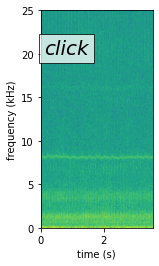

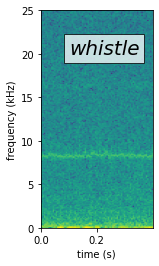

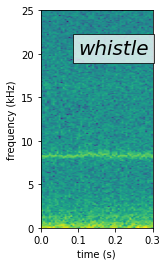

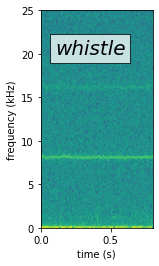

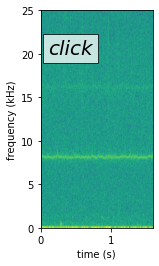

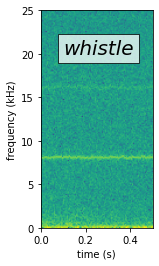

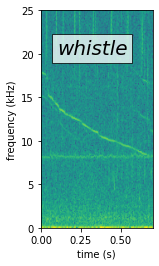

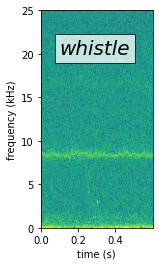

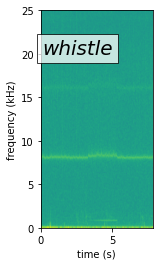

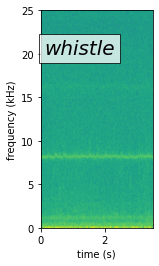

In [8]:
n = 10
for i in np.random.randint(0, len(colldf), n):
    
    visualiseSample(i, colldf, oFigDir)

Determine sampling rate and NFFT

In [9]:
i=3
thisRec = colldf.iloc[i].to_dict()
yi, sr = lb.core.load(thisRec['file'], sr=None,offset=thisRec['start'],duration=thisRec['duration'])
fft_ws = 512
print("Sampling rate {}, NFFT {}".format(sr, fft_ws))

Sampling rate 50000, NFFT 512


## Feature extraction 

### Create feature extraction pipeline

In [66]:
#### initialise transformation settings
def get_transformation_pipeline():
    fft_ws = 512
    sr = 50000
    filt = 'band_pass_filter'
    filtDi = {"fs": sr, "lowcut": 1500, "highcut": 2400, "order": 5}
    #T_settings.append(('bandFilter', (filt, filtDi)))
    T_settings = []
    prepro = 'maxabs_scale'
    preproDict = {}
    T_settings.append(('normaliseWF', (prepro, preproDict)))
    auD = {}
    auD['fs'] = sr
    auD['NFFT'] = fft_ws
    auD['overlap'] = 0
    auD['n_mels'] = 8
    audioF = 'melspectro'
    T_settings.append(('Audio_features', (audioF, auD)))
    summDict = {'Nslices': 5, 'normalise': True}
    summType = 'splitting'
    T_settings.append(('summ', (summType, summDict)))
    return fex.makeTransformationsPipeline(T_settings)

Tpipe = get_transformation_pipeline()
feExFun=Tpipe.fun


### Feature representation of one sample

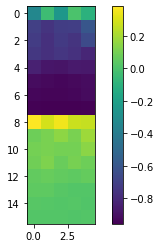

In [11]:
plt.imshow(feExFun(yi).T)
plt.colorbar()

### Extract features of the whole collection

This step can take quite some time (ca. 5 minutes in my 2019 MacBook). You can save time by reducing the size of the collection. 

In [12]:
from pylotwhale.signalProcessing.signalTools import wav2waveform, waveformPreprocessingFun, audioFeaturesFun
from tqdm import tqdm
def fwavLCollection2datXy(wavLabelCollection, fs=None, featExtFun=None):
    """
    Returns the data object of a collection of labelled wavs
        ..... call type (classification) ....    
    Used in experiment_callClf.ipynb
    Parameters
    ----------
    wavLabelCollection : list of tuples/list
        tu[0] : path to wav file
        tu[1] : wav label
    featExtFun : callable
    Return
    ------
    > datO: myML.dataXy_names
        data
    """

    datO = myML.dataXy_names() # initialise data object

    for wavF, l,start,duration in tqdm(wavLabelCollection):

        waveForm, fs = lb.core.load(wavF,sr=None,offset=start,duration=duration)#, normalize=False)
        M = featExtFun(waveForm)
        datO.addInstances(np.expand_dims(M.flatten(), axis=0), [l])

        #print(np.shape(M0), datO.shape, np.shape(datO.y), os.path.basename(wavF))
    return datO

In [13]:
colldf[colldf['duration']<5].iloc[:20].head()

,path,start,duration,end,label,file
0,012213d40662f86e8f775379bbf94dec,61.186,2.500,63.686,whistle,/content/data/dataset1/012213d40662f86e8f77537...
2,0159af9f3ca04ada46f0c353ac210bb8,161.482,1.000,162.482,click,/content/data/dataset1/0159af9f3ca04ada46f0c35...
3,0271a0818427d7fae7afde67bf49ba30,91.563,1.000,92.563,click,/content/data/dataset1/0271a0818427d7fae7afde6...
4,0271a0818427d7fae7afde67bf49ba30,125.627,1.316,126.943,click,/content/data/dataset1/0271a0818427d7fae7afde6...
5,0271a0818427d7fae7afde67bf49ba30,135.325,1.000,136.325,click,/content/data/dataset1/0271a0818427d7fae7afde6...


In [14]:
import random

In [15]:
def get_dataset(df,fs=None, featExtFun=None,decimas_de_segundo=5,noise=2):
    #duration=decimas de segundo
    datO = myML.dataXy_names() # initialise data object
    list_files=df.file.unique()                                    
    for path in tqdm(list_files):
        full_duration=lb.get_duration(filename=path)*10
        df_aux=df[df['file']==path]
        
        for i in range (0,int(round(full_duration,0)),decimas_de_segundo):
        
            df_with_values=df_aux[(df_aux['start']<i/10)&(df_aux['end']>(i+decimas_de_segundo)/10) ]
            
            if df_with_values.empty:
                label='noisy'
                #to avoid only add noisy
                if random.randint(0, 1000)>noise*10:
                    continue
            else:

                label=df_with_values.iloc[0]['label']
          
            waveForm, fs = lb.core.load(path,sr=fs,offset=i/10,duration=decimas_de_segundo/10)#, normalize=False)
            M = featExtFun(waveForm)
            datO.addInstances(np.expand_dims(M.flatten(), axis=0),[label]) #coger aqui el nombre en lugar del path

    return datO

In [16]:
colldf.label.unique()

array(['whistle', 'cetaceans_allfreq', 'click', 'allfreq'], dtype=object)

In [37]:
#@title Escogiendo una portion de los datos
label = "todas las etiquetas que me siento poderoso" #@param ["allfreq", "cetaceans_allfrq", "click", "whistle", "todas las etiquetas que me siento poderoso"]
quiero_solo_un_fragmento = True #@param {type:"boolean"}
porcentaje_del_fragmento = 0.05 #@param {type:"slider", min:0, max:1, step:0.01}
porcentaje_de_ruido = 1 #@param {type:"slider", min:0, max:100, step:0.1}
decimas_de_segundo = 5 #@param {type:"integer"}

if not label=="todas las etiquetas que me siento poderoso":
    colldf_temporal=colldf[colldf['label']==label]
else:
    label='todas'
if quiero_solo_un_fragmento:
    colldf_temporal=colldf.sample(frac=porcentaje_del_fragmento)


In [38]:
print('shape original',colldf.shape)
print('shape sampleado',colldf_temporal.shape)
colldf_temporal.shape

shape original (5455, 6)
shape sampleado (273, 6)


(273, 6)

In [39]:
classes = colldf_temporal['label'].unique().tolist()+ ['noisy']
lt = myML.labelTransformer(classes)
print("Classes we train on: {}, \nencoded by {}".format(lt.classes_, 
                                                      lt.nom2num(lt.classes_)))

Classes we train on: ['allfreq' 'cetaceans_allfreq' 'click' 'noisy' 'whistle'], 
encoded by [0 1 2 3 4]


In [40]:
wavsLabs_coll = colldf_temporal[['file', 'label','start','duration','end']]
datO = get_dataset(df=wavsLabs_coll, fs=sr, 
                                featExtFun=feExFun,
                   decimas_de_segundo=decimas_de_segundo,
                   noise=porcentaje_de_ruido)

100%|██████████| 154/154 [04:16<00:00,  1.66s/it]


### Read data into features matrix X and labels vector y

In [41]:
# load data into matrix
X = datO.X
# load labels in to features matrix
y_names = datO.y_names
# convert labels into numerical labels
y = lt.nom2num(y_names)

print("Class counts", datO.targetFrequencies())

Class counts {'whistle': 576, 'noisy': 1770, 'click': 362, 'cetaceans_allfreq': 646}


### Visualise features

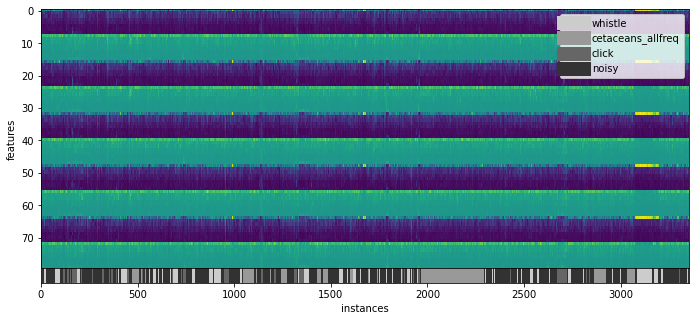

In [42]:
myML.plXy(X.T, y_names, figsize=(10,4), cmapName_Fig='viridis')

oFig = os.path.join(oFigDir, Tpipe.string + '.png')

oFig = os.path.join(oFigDir, 'feature_matrix-{}.png'.format('_'.join(classes)))
#plt.savefig(oFig, bbox_inches='tight')

## Train model

### Split data into train and test sets and shuffle samples

Counter({3: 1590, 1: 582, 4: 517, 2: 329}) Counter({3: 180, 1: 64, 4: 59, 2: 33})


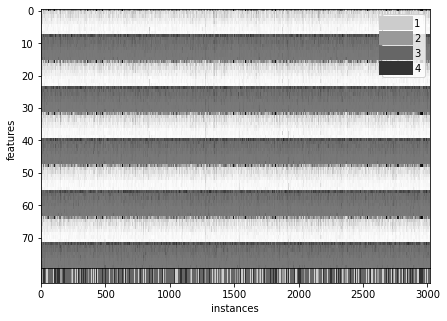

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=0)

myML.plXy(X_train.T, y_train) # visualise train set
print(Counter(y_train), Counter(y_test))

In [44]:
y_train.shape

(3018,)

### Carry out a grid search to tune classifier hyperparameters

Classifier settings

In [45]:
lt.nom2num(lt.classes_)
lt.classes_
lt.nom2num('0')


ERROR! y contains new labels


In [46]:
clf_settings = svc_rbf #random_forest #svc_rbf# # svc_l #
cv = 2  # cross validation folds for hyperparameter tuning via grid search
scoring = mt.make_scorer(mt.f1_score, labels=lt.nom2num(lt.classes_), average='macro') #'accuracy'

## define clf pipeline
clf_pipe = []
clf_pipe.append((clf_settings.pipeStep_name,  clf_settings.fun))
pipe = Pipeline(clf_pipe)
print("Clf pipeline:", clf_pipe)

## grid search parameters
paramsDi = {}
paramsDi.update(clf_settings.grid_params_di)
gs_grid = [paramsDi]
print("\nGrid search parameters:", paramsDi)
gs = GridSearchCV(estimator=pipe,
                  param_grid=gs_grid,
                  scoring=scoring,
                  cv=cv,
                  n_jobs=-1)

Clf pipeline: [('clf', SVC())]

Grid search parameters: {'clf__C': [0.1, 1.0, 10.0, 100], 'clf__gamma': [0.1, 1.0, 10.0]}


### Print all settings

In [47]:
print(Tpipe.string)
print(scoring, cv)
print("Clf pipeline:", clf_pipe)
print("Grid search parameters:", paramsDi)

-normaliseWF-maxabs_scale-Audio_features-melspectro-fs_50000-NFFT_512-overlap_0-n_mels_8-summ-splitting-Nslices_5-normalise_True
make_scorer(f1_score, labels=[0 1 2 3 4], average=macro) 2
Clf pipeline: [('clf', SVC())]
Grid search parameters: {'clf__C': [0.1, 1.0, 10.0, 100], 'clf__gamma': [0.1, 1.0, 10.0]}


### Fit model

This step can take a while 

In [48]:
gs = gs.fit(X_train, y_train)

# print scores
clf_svc_best = gs.best_estimator_
print(scoring, clf_svc_best )
print(gs.best_score_)

make_scorer(f1_score, labels=[0 1 2 3 4], average=macro) Pipeline(steps=[('clf', SVC(C=10.0, gamma=1.0))])
0.3423247001813968


In [60]:
model_name=f'{label}_{round(gs.best_score_,2)}_{decimas_de_segundo}_{porcentaje_de_ruido}.pickle'
pickle.dump(
        clf_svc_best, open(model_name, 'wb')
    )

print score

## Evaluate model on test set

### Print P, R and f1 scores for test collection

Scores by class and scoring summary

## Evaluate over the test set

                   precision    recall  f1-score   support

cetaceans_allfreq       0.40      0.22      0.28        64
            click       0.38      0.36      0.37        33
            noisy       0.59      0.82      0.69       180
          whistle       0.63      0.20      0.31        59

         accuracy                           0.55       336
        macro avg       0.50      0.40      0.41       336
     weighted avg       0.54      0.55      0.51       336



(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f58dc05aed0>)

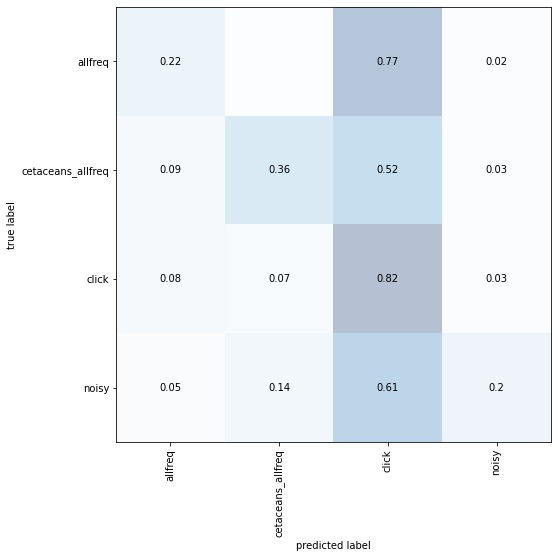

In [49]:
y_true, y_pred = y_test, clf_svc_best.predict(X_test)
print(mt.classification_report(y_true, y_pred, target_names=lt.num2nom(list(set(y)))))

## confusion matrix
cm = mt.confusion_matrix(y_true, y_pred)  # counts
cm_n = myML.scale(cm, normfun=myML.colCounts2colFreqs) # normalised for each class

fig, ax = evT.plConfusionMatrix(cM=cm_n, labels=lt.classes_, display_nums=False, figsize=(8, 8))# 
                                #outFig='/Users/florencia/Desktop/text.png',
                                #alpha=0.53, display_nums=False)

pT.display_numbers(fig, ax, cm_n, 10, 
                   fmt=lambda x: np.round(x, decimals=2), # display numbers with a 2 digit precision
                   condition=lambda x: x>0) # omit zeros

#ofig = os.path.join(oDir, 'CM-normalised.png')
#fig.savefig(ofig,  bbox_inches='tight')

In [71]:
from joblib import Parallel, delayed


In [128]:
import warnings
def get_dataset_submission(list_files, featExtFun=None, duration=10):
    # duration en base 100
    def get_M(path, featExtFun):
        warnings.simplefilter(action='ignore', category=FutureWarning)
        list_M = []
        list_i = []
        list_duration = []
        list_path = []
        full_duration = lb.get_duration(filename=path) * 10

        for i in range(0, int(round(full_duration, 0)), duration):

            waveForm, _ = lb.core.load(path, sr=50000, offset=i / 10, duration=duration / 10)  # , normalize=False)
            M = featExtFun(waveForm)
            list_M.append(M)
            list_i.append(i/10)
            list_duration.append(duration/10)
            list_path.append(path) #elimando extension

        return list_M, list_i, list_duration, list_path

    datO = myML.dataXy_names()  # initialise data object

    outputs = Parallel(n_jobs=-1)(
        delayed(get_M)(path, featExtFun) for path in tqdm(list_files, desc='Gathering audio', mininterval=25)
    )

    for job in tqdm(outputs):
        for M, i, duration, path in zip(*job):
            datO.addInstances(np.expand_dims(M.flatten(), axis=0), [f'{i},{i+duration},{os.path.split(path)[-1].split(".")[0]}'])

    return datO

In [129]:
from pathlib import Path
import pickle
from os import pathsep

list_of_files=list(Path('/content/data/dataset1/submission').glob('*.wav'))[:14]
decoder = dict(zip(lt.nom2num(y_names),y_names))

Tpipe = get_transformation_pipeline()
feExFun=Tpipe.fun

datO = get_dataset_submission(list_files=list_of_files, featExtFun=feExFun,duration=decimas_de_segundo)
X_test = datO.X
Y = datO.y_names
#if you want to do differents models
models = {
    'whistle':'trash/version_1/whistle_0.61_10_7.pickle',
    'cetaceans_allfreq':'trash/version_1/cetaceans_allfreq_0.58_10_17.pickle',
    'click': 'trash/version_1/click_0.7_10_4.pickle',
    'allfreq':'trash/version_1/allfreq_0.65_10_17.pickle',
}
dfs = []

loaded_model = pickle.load(open(model_name, 'rb'))
predictions_this_clase = loaded_model.predict(X_test)

df = pd.DataFrame()
df['label_encode'] = predictions_this_clase
df['label'] = df['label_encode'].replace(decoder)

df['information'] = Y
df[['start', 'end', 'path']] = df['information'].str.split(',', expand=True)
df[['filename']] = df['path'].str.split(pathsep, expand=True)
df = df.drop(df[df.label == 'noisy'].index)
df = df.drop(columns='path')
df.rename({'filename': 'path'}, axis=1, inplace=True)
df = df[['path', 'start', 'end', 'label']]
df_aux=df.copy(deep=True)
df_aux['duracion']=df_aux['end'].astype(float)-df_aux['start'].astype(float)
print('duración media de lo que has calculado por clase',
      df_aux.groupby(['label']).duracion.sum())
df.to_csv('/content/submision.csv', index=False)




Gathering audio: 100%|██████████| 14/14 [00:15<00:00,  1.12s/it]


  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.78it/s]

 43%|████▎     | 6/14 [00:00<00:00, 12.62it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.52it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  7.24it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.03it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  4.84it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  3.94it/s]

100%|██████████| 14/14 [00:02<00:00,  5.29it/s]


duración media de lo que has calculado por clase label
cetaceans_allfreq    411.0
click                 31.5
whistle               62.0
Name: duracion, dtype: float64


In [130]:
df.head()

,path,start,end,label
1,01767f8a26ee7958bdaad80f50f21873,0.5,1.0,cetaceans_allfreq
4,01767f8a26ee7958bdaad80f50f21873,2.0,2.5,cetaceans_allfreq
7,01767f8a26ee7958bdaad80f50f21873,3.5,4.0,cetaceans_allfreq
14,01767f8a26ee7958bdaad80f50f21873,7.0,7.5,cetaceans_allfreq
21,01767f8a26ee7958bdaad80f50f21873,10.5,11.0,cetaceans_allfreq


In [131]:
df.to_csv('/content/submision.csv', index=False)


trash

In [ ]:


Tpipe = get_transformation_pipeline()
feExFun=Tpipe.fun

datO = get_dataset(list_files=list_of_files, featExtFun=feExFun)
X_test = datO.X
Y = datO.y_names
path = 'trash\cetacean.pickle'
models = {
    'whistle':'trash/version_1/whistle_0.61_10_7.pickle',
    'cetaceans_allfreq':'trash/version_1/cetaceans_allfreq_0.58_10_17.pickle',
    'click': 'trash/version_1/click_0.7_10_4.pickle',
    'allfreq':'trash/version_1/allfreq_0.65_10_17.pickle',
}
dfs = []

loaded_model = pickle.load(open(model_name, 'rb'))
predictions_this_clase = loaded_model.predict(X_test)
value_to_label = 1 if label == 'whistle' else 0

df = pd.DataFrame()
df['label_encode'] = predictions_this_clase
df['label'] = np.where(df['label_encode'] == value_to_label, label, 'remove')

df['information'] = Y
df[['start', 'end', 'path']] = df['information'].str.split(',', expand=True)
df[['filename']] = df['path'].str.split(pathsep, expand=True)
df = df.drop(df[df.label == 'remove'].index)
df = df.drop(columns='path')
df.rename({'filename': 'path'}, axis=1, inplace=True)
df = df[['path', 'start', 'end', 'label']]

df 
df_final.to_csv('trash/submision.csv', index=False)
# df=pd.read_csv('submision.csv')
# df['start']=df['start'].astype(float)
# df['end']=df['end'].astype(float)
# df = df.groupby(['path', 'label']).apply(concatenate).reset_index().drop(columns='level_2')
# df.to_csv('submision_clean.csv',index=False)
# print(df_final)

In [ ]:
path='submission_final.csv'

In [ ]:
df=pd.read_csv(path)

In [ ]:
df.sort_values('start').head(30)

In [ ]:
df_final=pd.concat([df_aux,df_cetacean])

In [ ]:
df_final

In [ ]:
df_final.to_csv('limpiopython.csv',index=False)

In [ ]:
df_final['duration']=df_final['end']-df_final['start']

In [ ]:
df_final.groupby('label')['duration'].sum()